<a href="https://colab.research.google.com/github/nguyenhieuec/my-python-useful-short-code/blob/master/Greedy_algorithm_in_trading_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install intrinio-sdk

     |████████████████████████████████| 788kB 4.9MB/s 


In [0]:
import intrinio_sdk 

In [0]:
from __future__ import print_function
import time
from datetime import datetime, date, timedelta
import intrinio_sdk
from intrinio_sdk.rest import ApiException
from pprint import pprint

intrinio_sdk.ApiClient().configuration.api_key['api_key'] = 'OjhjNjdlNGY2ZTYyNTVlZGVhNzk0NzM4ZDdhYjY4NDU4'

security_api = intrinio_sdk.SecurityApi()

identifier = 'AAPL' # str | A Security identifier (Ticker, FIGI, ISIN, CUSIP, Intrinio ID)
start_date = str(date.today() - timedelta(days = 1500)) # date | Get historical data on or after this date (optional)
end_date = str(date.today()) # date | Get historical date on or before this date (optional)
frequency = 'daily' # str | Sort by date `asc` or `desc` (optional)
next_page = '' # str | Gets the next page of data from a previous API call (optional)

try:
    api_response = security_api.get_security_stock_prices(identifier, start_date=start_date, end_date=end_date, frequency=frequency, page_size = 10000) 
#     pprint(api_response)
except ApiException as e:
    print("Exception when calling SecurityApi->get_security_historical_data: %s\n" % e)

In [0]:
security_api.get_security_stock_prices?

In [0]:
type(api_response)

intrinio_sdk.models.api_response_security_historical_data.ApiResponseSecurityHistoricalData

In [0]:
# Note: For a Pandas DataFrame, import Pandas and use pd.DataFrame(api_response.intraday_prices_dict) 
import pandas as pd
import matplotlib.pyplot as plt 
import json

In [85]:
data_raw = pd.DataFrame(api_response.stock_prices_dict) 
list(data_raw)

['adj_close',
 'adj_high',
 'adj_low',
 'adj_open',
 'adj_volume',
 'close',
 'date',
 'frequency',
 'high',
 'intraperiod',
 'low',
 'open',
 'volume']

In [86]:
df = data_raw.drop(['adj_close',
 'adj_high',
 'adj_low',
 'adj_open',
 'adj_volume',
 'frequency',
 'high',
 'intraperiod',
 'low',
 'open',
 'volume'],axis=1)

df.date = pd.to_datetime(df.date)

df.sort_values(by=['date'], inplace=True)
type(df.date)

pandas.core.series.Series

In [0]:
df[-1:]
df.to_csv('df')

In [51]:
# Select duplicate rows except first occurrence based on all columns
duplicateRowsDF = df[df.duplicated()]
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF)


Duplicate Rows except first occurrence based on all columns are :
Empty DataFrame
Columns: [close, date]
Index: []


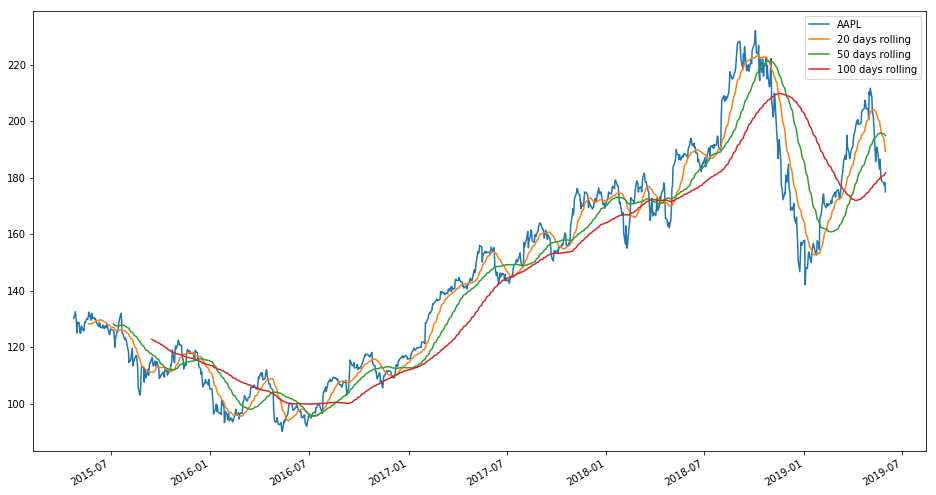

In [88]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(16,9))

short_rolling_aapl = df['close'].rolling(window=10).mean()
short14_rolling_aapl = df['close'].rolling(window=14).mean()
short20_rolling_aapl = df['close'].rolling(window=20).mean()

medium_rolling_aapl = df['close'].rolling(window=50).mean()

long_rolling_aapl = df['close'].rolling(window=100).mean()
long200_rolling_aapl = df['close'].rolling(window=200).mean()

date = df.date.astype('O')

ax.plot(date, df.close, label = "AAPL");
# ax.plot(date, short_rolling_aapl, label='10 days rolling')
# ax.plot(date, short14_rolling_aapl, label='14 days rolling')
ax.plot(date, short20_rolling_aapl, label='20 days rolling')
ax.plot(date, medium_rolling_aapl, label='50 days rolling')
ax.plot(date, long_rolling_aapl, label='100 days rolling')

fig.autofmt_xdate()
ax.legend();
# ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

"""Buying a Call - You have the right to buy a security at a predetermined price.
Selling a Call - You have an obligation to deliver the security at a predetermined price to the option buyer.
Buying a Put - You have the right to sell a security at a predetermined price.
Selling a Put - You have an obligation to buy the security at a predetermined price to the option buyer.
https://www.investopedia.com/articles/optioninvestor/10/sell-puts-benefit-any-market.asp
"""

#By the way: if we follow the MA and elliot wave strategy I should Buying a Put.

In [0]:
#@title Implement greedy trade function on AAPL
# So the idea is when the price at time t + 1 > t : buy and vice versa, buy more and hold when condition met.
# to KIS - Keep it simple: we just trade on the price with the same volume at daily, every time nothings else matter

#funding the money:
# import pandas as pd
def trade(df,vol,fund = 1000000,debug = False):
  """
  df: our data frame with 2 column date and close price
  vol: volume of stock when you buy/sell
  fund: default is 1.000.000
  debug: for check inside the loop
  tmp: track your portfolio's price
  """
  stock = 0
  pl = 0
  tmp = 0
  
  for i in range(1,len(df['date'])):
      if (df.iloc[i]['close'] > df.iloc[i-1]['close']) or (df.iloc[i]['close'] == df.iloc[i-1]['close']):
          stock += vol
          fund = round(fund - vol * (df.iloc[i]['close']),3)
          tmp += vol * (df.iloc[i]['close'])
          if debug == True:
            print('buy at', str(df.iloc[i]['close']), df.iloc[i]['date'],'our fund now is:', str(fund) )      
      elif (df.iloc[i]['close'] < df.iloc[i-1]['close']) and (stock > 0):
          pl = round(stock * df.iloc[i]['close'] - tmp,3)
          fund = round(fund + tmp + pl,3)
          stock = 0
          tmp = 0
          if debug == True:
            print('sell at', str(df.iloc[i]['close']),'with p/l is' ,str(pl), df.iloc[i]['date'], 'our fund now is:', str(fund) )      
          

  print('End of trade', str(fund))


In [0]:
# 996108.0 - 127.62*10

In [173]:
trade(df,10,10000)

End of trade 11287.25


To do:
1. Add T + 3 to sell stock
2. Try another condition in sell stock.
3. Add more stock